The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [23]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic, bin_occurrences
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.2e-3

In [24]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [25]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [26]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [40]:
def load_exp_data(direc, cut=None, layer_size=20, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if reverse:
        file_names = [f for f in reversed(file_names)]
    if cut is not None:
        file_names = file_names[:cut]
    
    file_name_count = range(0, len(file_names))
    for i_f in file_name_count:
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        
        summed_incoming_weights = loaded['w_r_e_summed']
        summed_incoming_weights_e_i = loaded['w_r_e_i_summed']
        
        try:
            exc_cells_initially_active = loaded['exc_raster']
            exc_cells_newly_active = None
        except KeyError as e:
            exc_cells_initially_active = loaded['exc_cells_initially_active'].astype(float)
            exc_cells_newly_active = loaded['exc_cells_newly_active'].astype(float)
            exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :] * dt
            if exc_cells_newly_active is not None and exc_cells_newly_active.shape[0] > 0:
                exc_cells_newly_active[0, :] = exc_cells_newly_active[0, :] * dt
        inh_raster = loaded['inh_raster']
        
        try:
            surviving_cell_indices = loaded['surviving_cell_indices'][0].astype(bool)
        except KeyError as e:
            surviving_cell_indices = np.ones(summed_incoming_weights.shape[1], dtype=bool)
        
        first_spk_times = process_single_activation(exc_cells_initially_active, 900)
        
        last_layer_active = 0
        layer_weights = []
        
        for i in range(0, len(first_spk_times), layer_size):
            layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
            if layer_active:
                last_layer_active = i/layer_size
        
            layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
            layer_weights.append(layer_weight)
        
        try:
            w_r_e = loaded['w_r_e']
        except KeyError as e:
            w_r_e = None
            
        try:
            vs = loaded['vs']
        except KeyError as e:
            vs = None
            
        try:
            gs = loaded['gs']
        except KeyError as e:
            gs = None
            
        data = {
            'index': i_f,
            'last_layer_active': last_layer_active,
            'first_spk_times': first_spk_times,
            'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
            'median_incoming_summed_weights': np.median(summed_incoming_weights),
            'std_incoming_summed_weights': np.std(summed_incoming_weights),
            'summed_incoming_weights': summed_incoming_weights,
            'mean_incoming_summed_weights_e_i': np.mean(summed_incoming_weights_e_i),
            'median_incoming_summed_weights_e_i': np.median(summed_incoming_weights_e_i),
            'std_incoming_summed_weights_e_i': np.std(summed_incoming_weights_e_i),
            'summed_incoming_weights_e_i': summed_incoming_weights_e_i,
            'exc_cells_initially_active': exc_cells_initially_active,
            'exc_cells_newly_active': exc_cells_newly_active,
            'inh_raster': inh_raster,
            'freqs': loaded['freqs'][0],
            'spk_bins': loaded['spk_bins'][0],
            'surviving_cell_indices': surviving_cell_indices,
            'w_r_e': w_r_e,
            'gs': gs,
            'vs': vs,
        }
        yield i_f, data

In [115]:
def sample_v_and_g(names, dropout=0, file_name_ext='', ylim=(0, 8)):
    scale = 1.4
    fig, axs = plt.subplots(4, 1, sharex=False, sharey=False, figsize=(10 * scale, 12 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    colors = ['red', 'blue']
    
    for idx, exp_dir_names in enumerate(all_dirs):        
        for j, exp_dir_name in enumerate(exp_dir_names):
            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[f'dropout_{dropout}']):
                for start_idx in [150, 350, 550, 750, 850]:
                    if data['vs'] is not None:
                        selected_vs = data['vs'][:, start_idx:start_idx + 20]
    #                     for c_idx in range(selected_vs.shape[1]):
                        axs[0].plot(np.arange(selected_vs.shape[0]) * 0.2e-3 * 1000, selected_vs.mean(axis=1), lw=0.3, color=colors[idx])
                        axs[1].plot(np.arange(selected_vs.shape[0]) * 0.2e-3 * 1000, selected_vs.std(axis=1), lw=0.3, color=colors[idx])
                    if data['gs'] is not None:
                        selected_gs = data['vs'][:, start_idx:start_idx + 20]
    #                     for c_idx in range(selected_gs.shape[1]):
                        axs[2].plot(np.arange(selected_gs.shape[0]) * 0.2e-3 * 1000, selected_gs.mean(axis=1), lw=0.3, color=colors[idx])
                        axs[3].plot(np.arange(selected_gs.shape[0]) * 0.2e-3 * 1000, selected_gs.std(axis=1), lw=0.3, color=colors[idx])

        
    axs[0].set_title('red = 8750, blue = 250')
#     axs[0].set_ylabel('Population spikes\nper activation')
#     axs[1].set_ylabel('Propagation speed')
    
# #     axs[0].set_ylim(0, 1)
#     axs[1].set_ylim(0)
    
    # axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
#     for i in range(2):
#         axs[i].set_xlim(65, 90)
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_4', f'dropout_{int(50 + dropout * 10)}_{file_name_ext}.png')

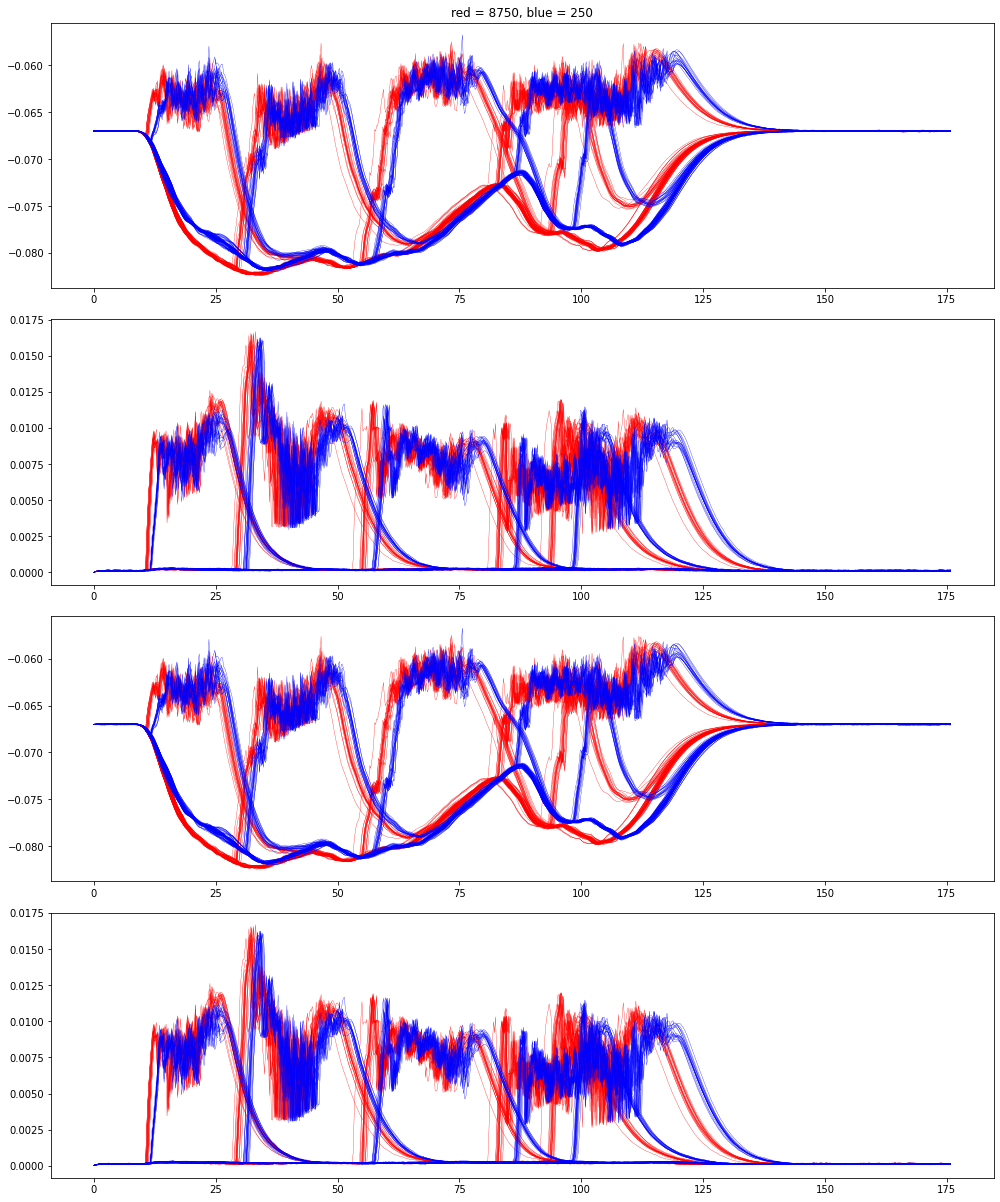

In [116]:
sample_v_and_g([
    'shrinking_weights_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_8750_2021-08-18--12:35--14:9861',
    'shrinking_weights_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_250_2021-08-18--12:07--26:9861',
])

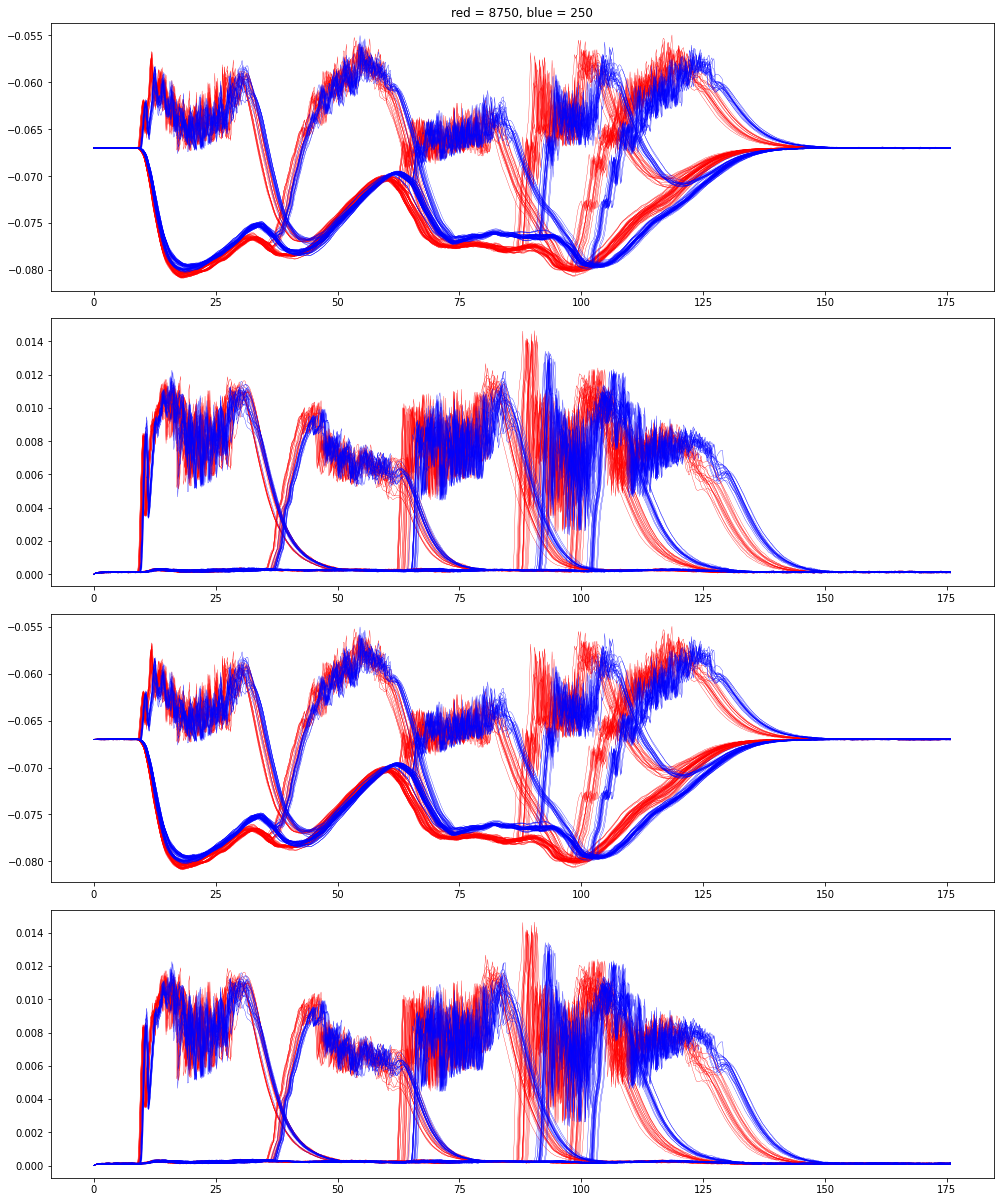

In [118]:
sample_v_and_g([
    'shrinking_weights_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_8750_2021-08-18--13:28--47:9861',
    'shrinking_weights_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_250_2021-08-18--12:39--54:9861',
])